In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
data = files.upload()

Saving final_data.csv to final_data.csv


Data Preparation

In [81]:
from sklearn.model_selection import train_test_split


df = pd.read_csv("final_data.csv")
print(df)

print("Data verified:")
print(f"Total samples: {len(df)}")
print(f"Clickbait (1): {len(df[df['label']==1])}")
print(f"News (0): {len(df[df['label']==0])}")

                                                    text  label
0                                     Should I Get Bings      1
1          Which TV Female Friend Group Do You Belong In      1
2      The New "Star Wars: The Force Awakens" Trailer...      1
3      This Vine Of New York On "Celebrity Big Brothe...      1
4      A Couple Did A Stunning Photo Shoot With Their...      1
...                                                  ...    ...
31597  To Make Female Hearts Flutter in Iraq, Throw a...      0
31598  British Liberal Democrat Patsy Calton, 56, die...      0
31599  Drone smartphone app to help heart attack vict...      0
31600  Netanyahu Urges Pope Benedict, in Israel, to D...      0
31601  Computer Makers Prepare to Stake Bigger Claim ...      0

[31602 rows x 2 columns]
Data verified:
Total samples: 31602
Clickbait (1): 15717
News (0): 15885


Visualiation

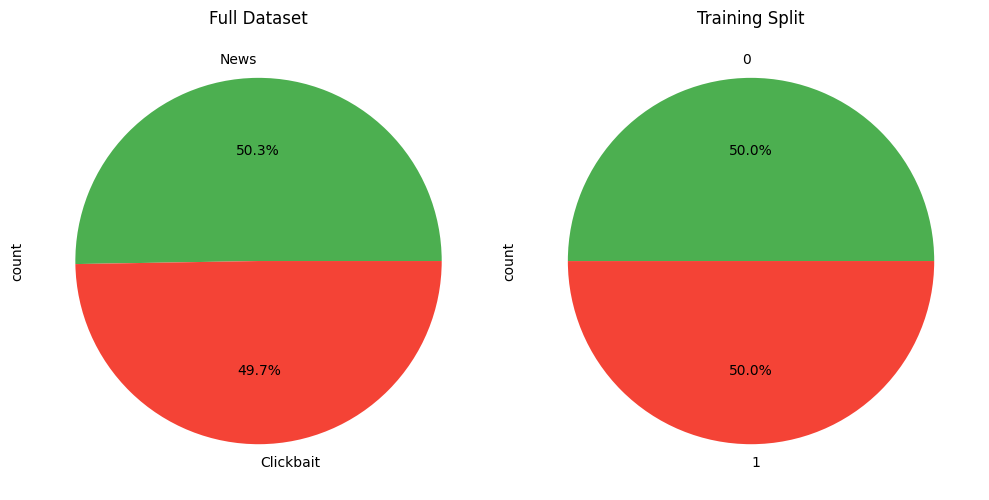

In [82]:
from wordcloud import WordCloud

# A. Class Distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df['label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#4CAF50','#F44336'],
    labels=['News','Clickbait'],
    title='Full Dataset'
)
plt.subplot(1,2,2)
pd.Series(y_train).value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['#4CAF50','#F44336'],
    title='Training Split'
)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

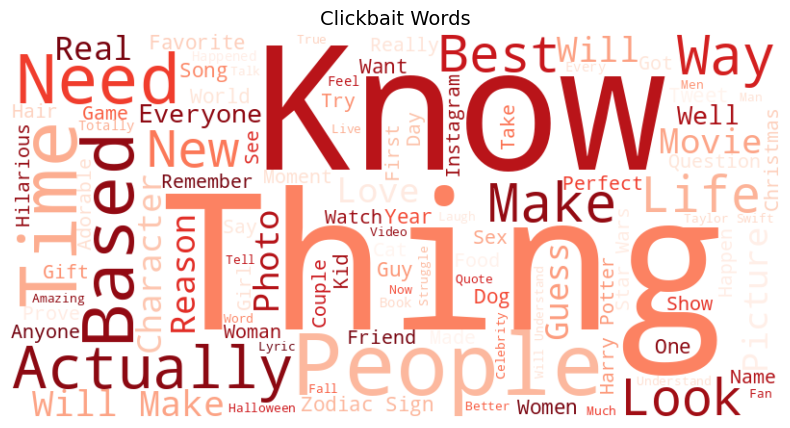

In [37]:
def generate_wordcloud(text, title, color):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        max_words=100
    ).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.savefig(f'wordcloud_{title.replace(" ", "_")}.png')
    plt.show()

generate_wordcloud(
    " ".join(df[df['label']==1]['text']),
    "Clickbait Words",
    'Reds'
)

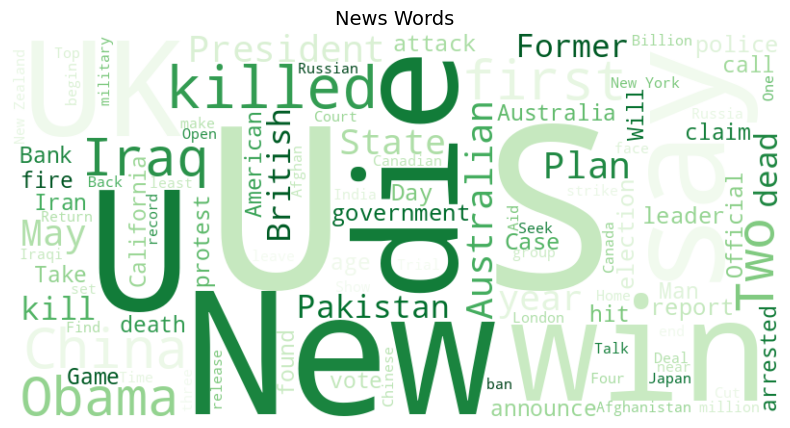

In [40]:
if 0 in df['label'].unique():
    generate_wordcloud(
        " ".join(df[df['label']==0]['text']),
        "News Words",
        'Greens'
    )

In [43]:

X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.3,
    random_state=42,
    stratify=df['label']
)


print(f"Training samples: {len(X_train)} ({len(X_train)/len(df):.0%})")
print(f"Testing samples:  {len(X_test)} ({len(X_test)/len(df):.0%})")

Training samples: 22400 (70%)
Testing samples:  9600 (30%)


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [57]:
tfidf_model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])
tfidf_model.fit(X_train, y_train)


feature_names = tfidf_model.named_steps['tfidf'].get_feature_names_out()
coefs = tfidf_model.named_steps['clf'].coef_[0]

# Evaluate
tfidf_acc = tfidf_model.score(X_test, y_test)
print(f"TF-IDF Accuracy: {tfidf_acc:.2f}")


TF-IDF Accuracy: 0.97


In [58]:
train_test_overlap = set(X_train).intersection(set(X_test))
print(f"Overlapping samples: {len(train_test_overlap)}")
print("Training class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTesting class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Overlapping samples: 0
Training class distribution:
label
0    0.500045
1    0.499955
Name: proportion, dtype: float64

Testing class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


Most predictive phrases:
['you', 'this', 'your', 'these', 'things']


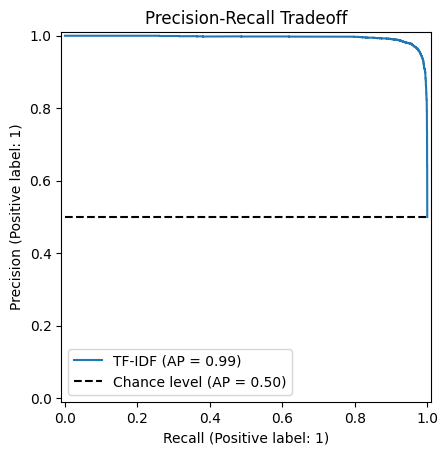

In [59]:
import numpy as np
print("Most predictive phrases:")
print([feature_names[i] for i in np.argsort(coefs)[-5:][::-1]])

from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(
    tfidf_model, X_test, y_test,
    name="TF-IDF",
    plot_chance_level=True
)
plt.title("Precision-Recall Tradeoff")
plt.savefig('precision_recall.png', dpi=120)





In [60]:
false_positives = X_test[(y_test==0) & tfidf_model.predict(X_test)==1]
print("False Positives (News mistaken for Clickbait):")
print(false_positives.head(3).values)

False Positives (News mistaken for Clickbait):
['Wagoner Retains His Optimism as He Bows Out'
 'Buying the Best Netbooks for  the Least-Bad Compromises'
 'Forget the Cigarette Lighter Adapter. Now You Can Dock Your iPod in the Car Radio.']


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = tfidf_model.predict(X_test)


print("TF-IDF Classification Report:")
print(classification_report(y_test, y_pred, target_names=['News', 'Clickbait']))


cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

TF-IDF Classification Report:
              precision    recall  f1-score   support

        News       0.96      0.97      0.97      4800
   Clickbait       0.97      0.96      0.97      4800

    accuracy                           0.97      9600
   macro avg       0.97      0.97      0.97      9600
weighted avg       0.97      0.97      0.97      9600


Confusion Matrix:
[[4679  121]
 [ 190 4610]]


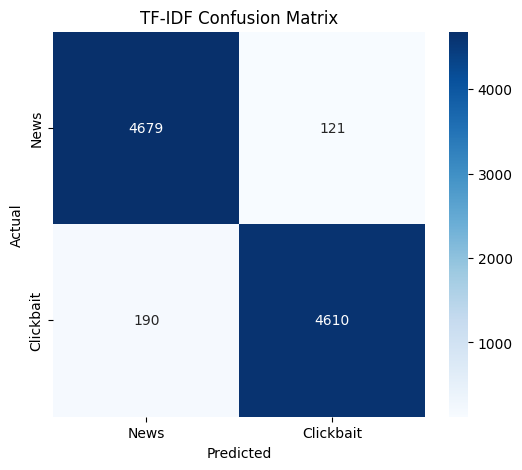

In [68]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['News', 'Clickbait'],
            yticklabels=['News', 'Clickbait'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('TF-IDF Confusion Matrix')
plt.savefig('tfidf_confusion_matrix.png', dpi=120, bbox_inches='tight')
plt.show()

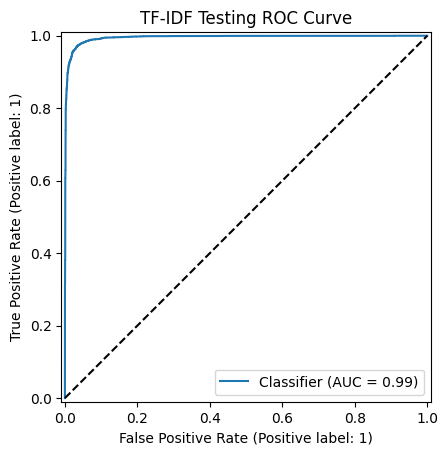

In [83]:
from sklearn.metrics import RocCurveDisplay

y_probs = tfidf_model.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_probs)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('TF-IDF Testing ROC Curve')
plt.savefig('tfidf_roc.png', dpi=120)
plt.show()

In [72]:
from sklearn.metrics import precision_recall_fscore_support

metrics = precision_recall_fscore_support(y_test, y_pred, average='binary')
pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Value': [metrics[0], metrics[1], metrics[2], tfidf_model.score(X_test, y_test)]
}).style.hide(axis="index").background_gradient(cmap='Blues')

Metric,Value
Precision,0.974424
Recall,0.960417
F1-Score,0.967370
Accuracy,0.967604


In [85]:
from ipywidgets import interact

def predict_headline(text):
    prob = tfidf_model.predict_proba([text])[0][1]
    print(f"Clickbait Probability: {prob:.2f}")
    print("Classification:", "Clickbait" if prob > 0.5 else "News")

interact(predict_headline, text="You won't believe what happens next!")

interactive(children=(Text(value="You won't believe what happens next!", description='text'), Output()), _dom_…

<function __main__.predict_headline(text)>